In [1]:
# Recurrent Neural Network

In [2]:
import numpy as np
import tensorflow as tf

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = bytes("<stripped %d bytes>"%size, 'utf-8')
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [3]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [5]:
# Preparing data

In [6]:
np.random.seed(0)
tf.set_random_seed(123)

In [7]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

In [8]:
def sin_with_noise(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x)+noise

In [9]:
T = 100
f = sin_with_noise(T)

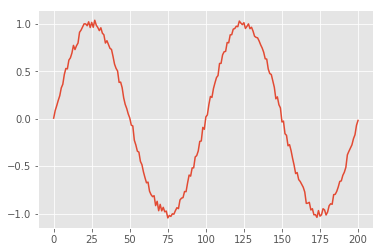

In [10]:
plt.plot(f)
plt.show()

In [11]:
total_length = 2 * T
sampling_length = 25

In [12]:
data = []
target = []

In [13]:
for i in range(0, total_length - sampling_length + 1):
    data.append(f[i: i+sampling_length])
    target.append(f[i+sampling_length])

In [14]:
X = np.zeros((len(data), sampling_length, 1), dtype=float)
Y = np.zeros((len(data), 1), dtype=float)

In [15]:
for i, seq in enumerate(data):
    for t, value in enumerate(seq):
        X[i, t, 0] = value
    
    Y[i, 0] = target[i]

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

In [17]:
# Building a model

In [24]:
class RNN(object):
    def __init__(self, graph, dim_input, dim_hiddens, dim_output, sampling_length):
        self.graph = graph
        self.dim_input = dim_input
        self.dim_hiddens = dim_hiddens
        self.dim_output = dim_output
        self.sampling_length = sampling_length
        
        self._x = None
        self._t = None
        self._batch_size = None

        self._y = None

        self._loss = None
        self._train_step = None
        
        self._sess = None
        
        self._history = {
            'acc': [],
            'loss': [],
            'val_acc': [],
            'val_loss': []
            
        }
    
    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial, name='W')
    
    def bias_variable(self, shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial, name='b')
    
    def inference(self, x, batch_size):
        cell = tf.contrib.rnn.BasicRNNCell(self.dim_hiddens[0])
        
        state = cell.zero_state(batch_size, tf.float32)
        
        with tf.name_scope('RNN_Layer_1'):
            with tf.variable_scope('RNN_1'):
                for t in range(self.sampling_length):
                    if t > 0:
                        tf.get_variable_scope().reuse_variables()
                    
                    cell_output, state = cell(x[:, t, :], state)
 
        with tf.name_scope('Output_Layer'):
            V = self.weight_variable([self.dim_hiddens[0], self.dim_output])
            c = self.bias_variable([self.dim_output])

            y = tf.matmul(cell_output, V) + c

        return y

    def loss(self, y, t):
        with tf.name_scope('Loss'):
            mse = tf.reduce_mean(tf.square(y - t))
        
        return mse
    
    def training(self, loss):
        with tf.name_scope('Train'):
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
            train_step = optimizer.minimize(loss)
        
        return train_step
 
    def compile(self):
        with self.graph.as_default():
            x = tf.placeholder(tf.float32, shape=[None, self.sampling_length, self.dim_input], name='x')
            t = tf.placeholder(tf.float32, shape=[None, self.dim_output], name='t')
            batch_size = tf.placeholder(tf.int32)
            
            y = self.inference(x, batch_size)

            loss = self.loss(y, t)
            train_step = self.training(loss)
        
        self._x = x
        self._t = t
        self._batch_size = batch_size
        
        self._y = y
        
        self._loss = loss
        self._train_step = train_step

    def fit(self, X_train, Y_train, X_test, Y_test, epochs=500, batch_size=10, verbose=1):
        N_train = len(X_train)
        n_batches = N_train // batch_size
        
        with self.graph.as_default():
            init = tf.global_variables_initializer()
            sess = tf.Session()
            sess.run(init)

            self._sess = sess

            for epoch in range(epochs):
                X_, Y_ = shuffle(X_train, Y_train)

                for i in range(n_batches):
                    start = i * batch_size
                    end = start + batch_size

                    sess.run(
                        self._train_step,
                        feed_dict={
                            self._x: X_[start:end],
                            self._t: Y_[start:end],
                            self._batch_size: batch_size
                        })

                val_loss_ = self._loss.eval(
                            session=sess,
                            feed_dict={
                                self._x: X_test,
                                self._t: Y_test,
                                self._batch_size: len(X_test)
                            })

                self._history['val_loss'].append(val_loss_)

                if verbose:
                    print("epoch: {0} / val_loss: {1} ".format(epoch, val_loss_))

            return self._history
    
    def show_graph_model(self):
        with self.graph.as_default():
            show_graph(tf.Session().graph_def)
            
    def show_graph_val_loss(self):
        fig = plt.figure(figsize=(16, 4))
        ax = fig.add_subplot(111)
        ax.plot(self._history['val_loss'])
        
        ax.set_title('Validation Loss')
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Validation Loss')
        
        plt.yscale('log')

        plt.show()
        
    def output(self, seq_original):
        seq = seq_original[:1]
        
        predicted = [None for _ in range(self.sampling_length)]
        
        for i in range(len(seq_original) - self.sampling_length + 1):
            y_ = self._y.eval(session=self._sess,
                              feed_dict={
                                  self._x: seq.reshape(1, self.sampling_length, self.dim_input),
                                  self._batch_size: 1
                              })
            
            seq = np.vstack([seq.reshape(self.sampling_length, self.dim_input)[1:], y_])
            
            predicted.append(y_.reshape(-1))

        return predicted

In [22]:
model = RNN(tf.Graph(),
            dim_input=1,
            dim_hiddens=[20],
            dim_output=1,
            sampling_length=25)

In [23]:
model.compile()

Tensor("x:0", shape=(?, 25, 1), dtype=float32)
Tensor("Placeholder:0", dtype=int32)


In [21]:
model.show_graph_model()

In [22]:
history = model.fit(X_train,
                    Y_train,
                    X_test,
                    Y_test,
                    epochs=400,
                    batch_size=10)

epoch: 0 / val_loss: 0.5138610601425171 
epoch: 1 / val_loss: 0.29116663336753845 
epoch: 2 / val_loss: 0.12221530079841614 
epoch: 3 / val_loss: 0.052406441420316696 
epoch: 4 / val_loss: 0.036985352635383606 
epoch: 5 / val_loss: 0.02832021936774254 
epoch: 6 / val_loss: 0.022878022864460945 
epoch: 7 / val_loss: 0.016731493175029755 
epoch: 8 / val_loss: 0.014748047105967999 
epoch: 9 / val_loss: 0.009217331185936928 
epoch: 10 / val_loss: 0.005959196016192436 
epoch: 11 / val_loss: 0.0041310726664960384 
epoch: 12 / val_loss: 0.0031483822967857122 
epoch: 13 / val_loss: 0.005087658297270536 
epoch: 14 / val_loss: 0.004203462973237038 
epoch: 15 / val_loss: 0.0027578668668866158 
epoch: 16 / val_loss: 0.0019892039708793163 
epoch: 17 / val_loss: 0.00197890168055892 
epoch: 18 / val_loss: 0.0020189268980175257 
epoch: 19 / val_loss: 0.001873855129815638 
epoch: 20 / val_loss: 0.0018503260798752308 
epoch: 21 / val_loss: 0.001961205620318651 
epoch: 22 / val_loss: 0.001693066209554672

epoch: 183 / val_loss: 0.0014189531793817878 
epoch: 184 / val_loss: 0.0012369710020720959 
epoch: 185 / val_loss: 0.0013188375160098076 
epoch: 186 / val_loss: 0.0014094060752540827 
epoch: 187 / val_loss: 0.001304452889598906 
epoch: 188 / val_loss: 0.0013163394760340452 
epoch: 189 / val_loss: 0.0016687322640791535 
epoch: 190 / val_loss: 0.0018824802245944738 
epoch: 191 / val_loss: 0.001348269754089415 
epoch: 192 / val_loss: 0.00163435866124928 
epoch: 193 / val_loss: 0.0013122817035764456 
epoch: 194 / val_loss: 0.0014394060708582401 
epoch: 195 / val_loss: 0.0015048978384584188 
epoch: 196 / val_loss: 0.001743614673614502 
epoch: 197 / val_loss: 0.001717898529022932 
epoch: 198 / val_loss: 0.0013520435895770788 
epoch: 199 / val_loss: 0.0013441252522170544 
epoch: 200 / val_loss: 0.0013281847350299358 
epoch: 201 / val_loss: 0.0013978703645989299 
epoch: 202 / val_loss: 0.00226662028580904 
epoch: 203 / val_loss: 0.0018636672757565975 
epoch: 204 / val_loss: 0.00160077074542641

epoch: 365 / val_loss: 0.001342710922472179 
epoch: 366 / val_loss: 0.0011425312841311097 
epoch: 367 / val_loss: 0.0024224561639130116 
epoch: 368 / val_loss: 0.001998268999159336 
epoch: 369 / val_loss: 0.0014016036875545979 
epoch: 370 / val_loss: 0.0013206658186390996 
epoch: 371 / val_loss: 0.0014718486927449703 
epoch: 372 / val_loss: 0.0013695646775886416 
epoch: 373 / val_loss: 0.0013313855743035674 
epoch: 374 / val_loss: 0.0015166515950113535 
epoch: 375 / val_loss: 0.0015170145779848099 
epoch: 376 / val_loss: 0.001345710945315659 
epoch: 377 / val_loss: 0.0016820458695292473 
epoch: 378 / val_loss: 0.0014521223492920399 
epoch: 379 / val_loss: 0.0012353970669209957 
epoch: 380 / val_loss: 0.0016210401663556695 
epoch: 381 / val_loss: 0.0012551606632769108 
epoch: 382 / val_loss: 0.001525849336758256 
epoch: 383 / val_loss: 0.0016918294131755829 
epoch: 384 / val_loss: 0.0014468289446085691 
epoch: 385 / val_loss: 0.00136459874920547 
epoch: 386 / val_loss: 0.001285384758375

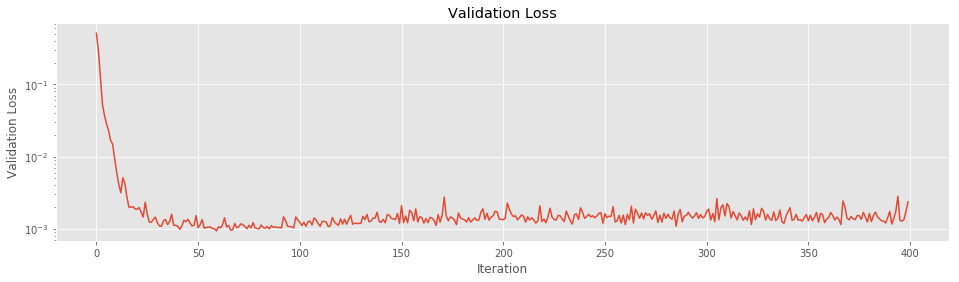

In [23]:
model.show_graph_val_loss()

In [24]:
# Confirm the result

In [25]:
predicted = model.output(X)

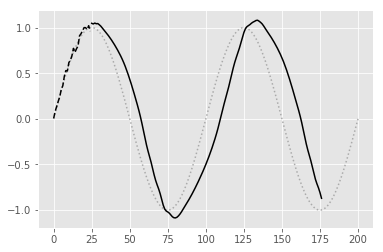

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sin_with_noise(T, ampl=0), linestyle='dotted', color='#aaaaaa')
ax.plot(X[0].reshape(-1), linestyle='dashed', color='black')
ax.plot(predicted, color='black')

plt.show()